In [1]:
import scanpy as sc

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
DATA_PATH = 'data/'

DATA_TYPE = '10X'

OUTPUT_PATH = 'outputs/PBMC10K/'

# Load data

In [4]:
adata = sc.read_h5ad(DATA_PATH+ 'pbmc_seurat_v4.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index'
    obsm: 'protein_counts'

# Preprocess

In [6]:
adata = adata[adata.obs['orig.ident'].isin(['P8_3', 'P8_0'])]

In [10]:
adata.obs['batch'] = adata.obs['orig.ident']

filtered out 520 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


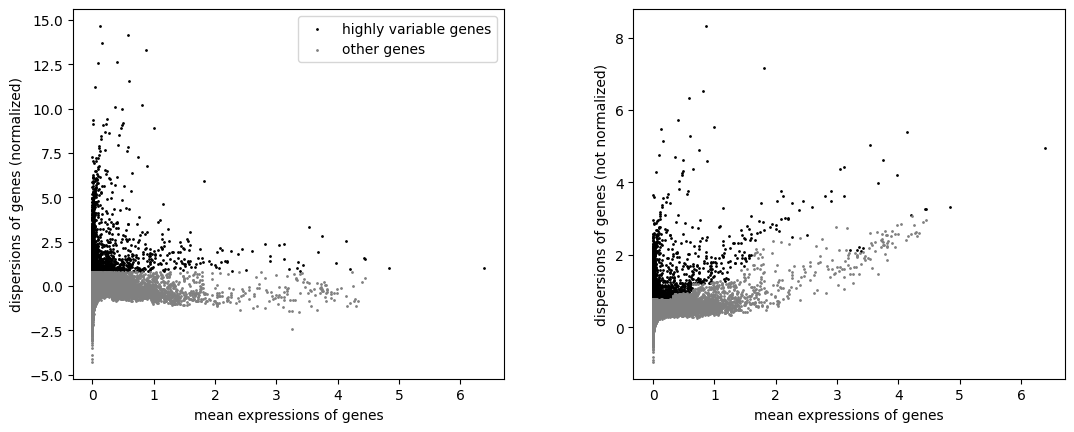

In [8]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [9]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


# Scanpy embeddings

In [11]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


In [12]:
sc.tl.leiden(adata, resolution=0.2)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

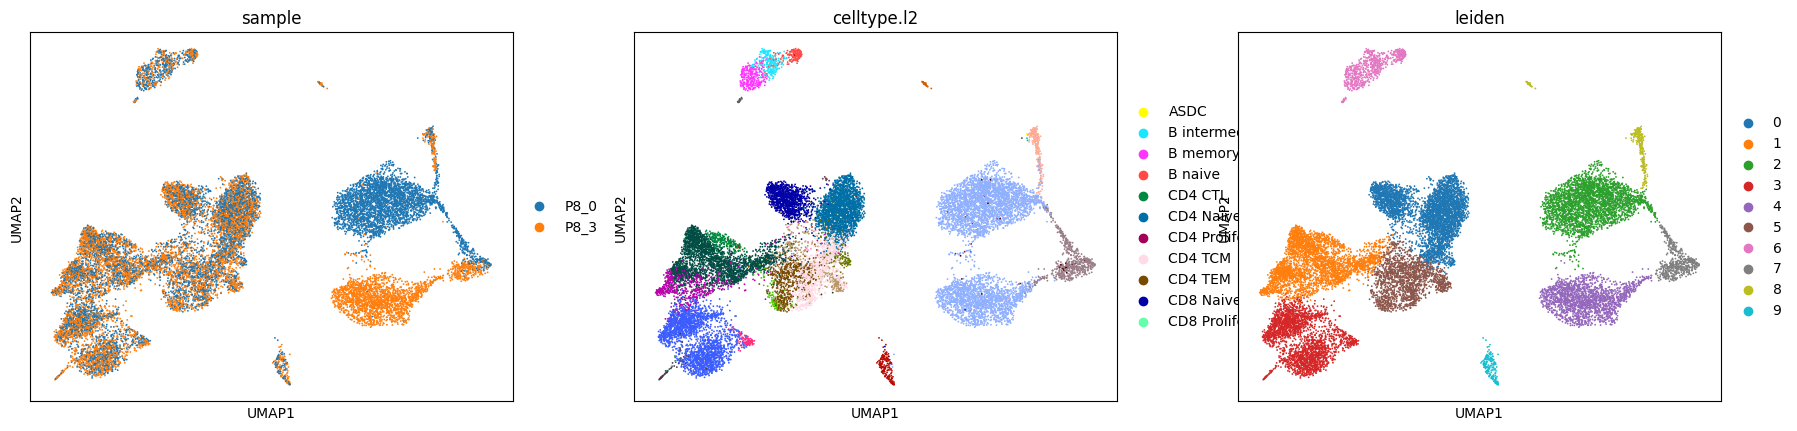

In [13]:
sc.pl.umap(adata, color=['sample', 'celltype.l2', 'leiden'])

In [14]:
adata.write(OUTPUT_PATH+'scanpy_adata.h5ad')

In [ ]:
adata = sc.read_h5ad(OUTPUT_PATH+'scanpy_adata.h5ad')

# BBKNN Integration

In [15]:
adata_1 = adata[adata.obs['batch']=='P8_0']
adata_2 = adata[adata.obs['batch']=='P8_3']
# print(adata_1)
# print(adata_2)

In [16]:
# Concatenate the datasets
adata_combined = adata_1.concatenate(adata_2, index_unique=None)



/scratch/5966272.1.korolevgroup-gpu-pub/ipykernel_153470/374954523.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_1.concatenate(adata_2, index_unique=None)


In [17]:
import bbknn

# Batch correction with BBKNN
bbknn.bbknn(adata_combined, batch_key='batch', computation='pynndescent')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [18]:
sc.tl.umap(adata_combined)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [47]:
sc.tl.leiden(adata_combined, resolution=0.12)

/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

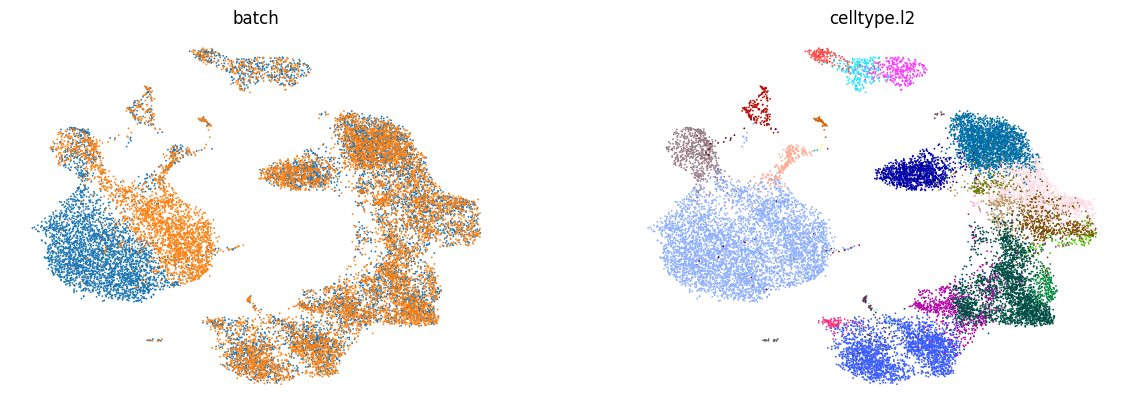

In [19]:
sc.pl.umap(adata_combined, color=['batch', 'celltype.l2'], legend_loc=None, frameon=False)

/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

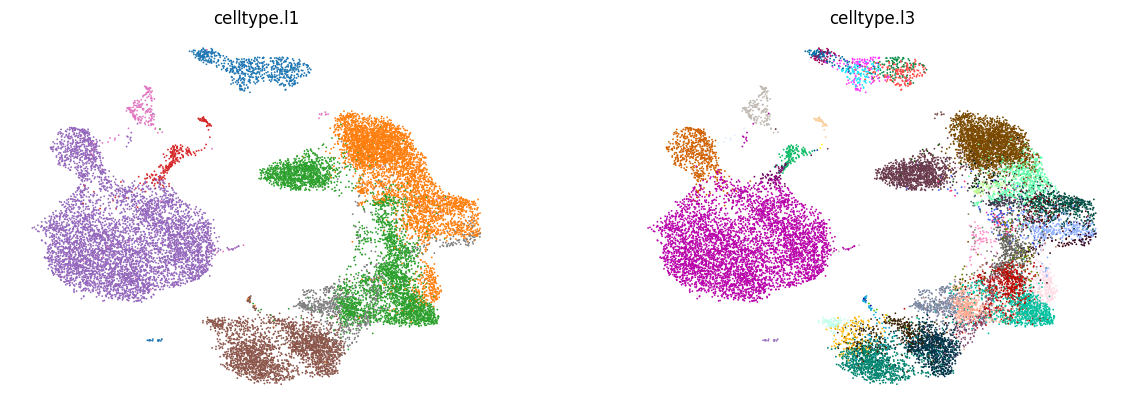

In [20]:
sc.pl.umap(adata_combined, color=['celltype.l1', 'celltype.l3'], legend_loc=None, frameon=False)

# BBKNN integration with inbalance

In [22]:
# Concatenate the datasets
adata_2a = adata_2[adata_2.obs['celltype.l1']!='NK']
adata_combined_ib = adata_1.concatenate(adata_2a, index_unique=None)



/scratch/5966272.1.korolevgroup-gpu-pub/ipykernel_153470/1793646593.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined_ib = adata_1.concatenate(adata_2a, index_unique=None)


In [23]:
import bbknn

# Batch correction with BBKNN
bbknn.bbknn(adata_combined_ib, batch_key='batch', computation='pynndescent')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [24]:
sc.tl.umap(adata_combined_ib)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [23]:
sc.tl.leiden(adata_combined_ib, resolution=0.2)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

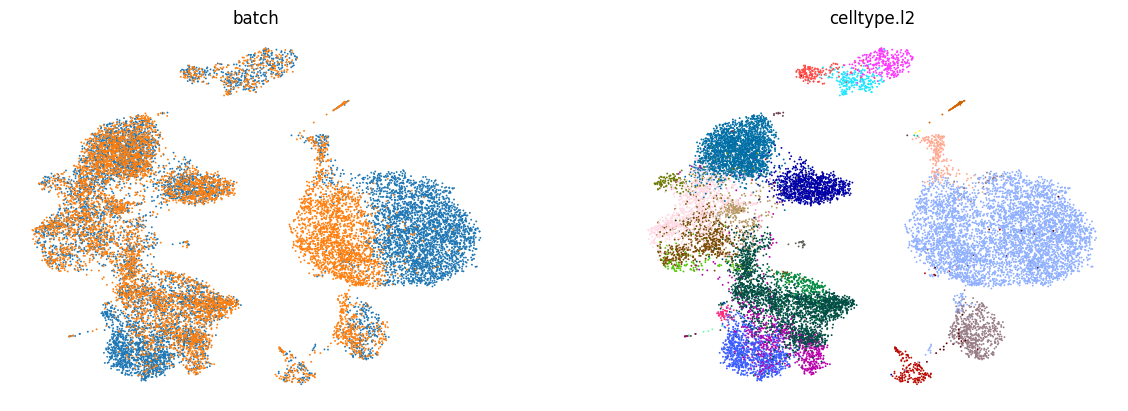

In [26]:
sc.pl.umap(adata_combined_ib, color=[ 'batch', 'celltype.l2'], legend_loc=None, frameon=False)

/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

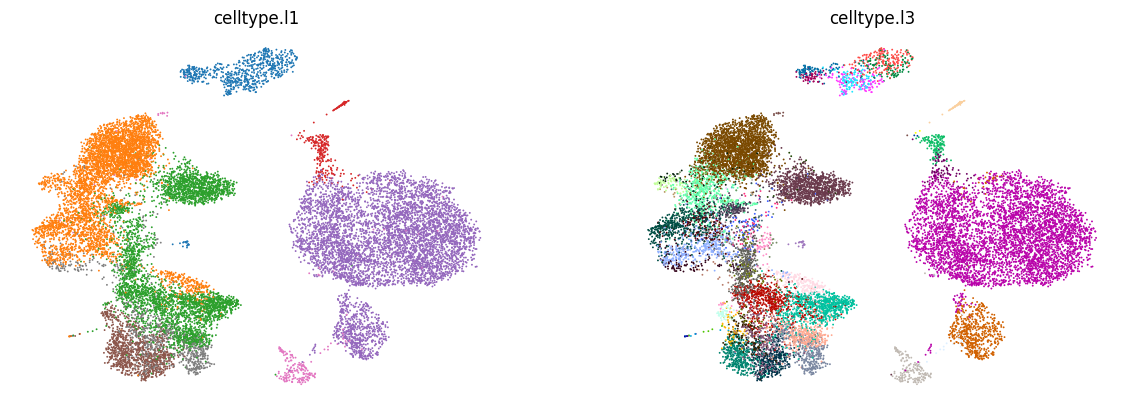

In [27]:
sc.pl.umap(adata_combined_ib, color=[ 'celltype.l1', 'celltype.l3'], legend_loc=None, frameon=False)